<a href="https://colab.research.google.com/github/CamilleVG/Datathon4Justice/blob/master/GeoPandasStarterFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Geopandas using the datathon data

### Goals:

1. Read and write shapefiles,
2. Perform statistical operations on the data, 
3. Visualize the results,
4. Start exploring the data.

Before we get started, we need to make sure the following folders/files are present: 
1. datathon_crashes
2. datathon_lights
3. Utah_Census_Tracts_2020
4. SLC_census_tracts.csv
5. census_data_2020.csv

To use this notebook:
1. download "datathon_sample_data.zip" from GitHub or the workshop google drive,
2. upload the zip file into the local Files directory for google colab,
3. start running the scripts below!

There are some packages we need to install as well:

In [6]:
#install geopandas (which for whatever reason is not standard)
!pip install geopandas
#install mapclassify (which is helpful for interactive exploration)
!pip install mapclassify

#unzip the uploaded data
!unzip Datathon4Justice/datathon_sample_data.zip

Archive:  Datathon4Justice/datathon_sample_data.zip
replace census_data_2020.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#import the main data packages
import numpy as np
import pandas as pd
import geopandas as gpd

#import the fancy map packages
import folium
import mapclassify

#tqdm provides nice progress bars 
from tqdm import tqdm

#import the general plotting package
import matplotlib.pyplot as plt

## Reading and writing shapefiles

First let's read in *all* of the data we'll be using.

In [ ]:
#read in the data about lights in SLC
path_to_lights = "./datathon_lights/datathon_lights.shp"
lights = gpd.read_file(path_to_lights)

#read in the data about crashes in SLC
path_to_crashes = "./datathon_crashes/datathon_crashes.shp"
crashes = gpd.read_file(path_to_crashes)

#read in the geometry of census tracts (for all of salt lake county)
path_to_utah = "./Utah_Census_Tracts_2020/CensusTracts2020.shp"
ut_tracts = gpd.read_file(path_to_utah)

#read in the census data
read_path =  "./census_data_2020.csv"
df = pd.read_csv(read_path).drop(columns = "Unnamed: 0")
df = df.astype({"county":"str","state":"str","tract":"str"})
df = df.rename(index = df.tract)
df = df.drop(columns = ["county","state","tract"])
df[df<0] = np.nan

#read in SLC tracts
tracts = pd.read_csv("./SLC_census_tracts.csv",header=None,dtype = str).to_numpy()

In [ ]:
#now let's take a look at what we're working with
#to just print the head of each dataframe, here's an easy-access addendum: .head()

print("lights:")
print("column names:"); print(lights.columns)
print(lights)

print("crashes:")
print("column names:"); print(crashes.columns)
print(crashes)

print("census tracts:")
print("column names:"); print(ut_tracts.columns)
print(ut_tracts)

print("census data:")
print("column names:"); print(df.columns)
print(df)

lights:
column names:
Index(['OBJECTID', 'TYPE', 'plan_', 'wattage', 'Location', 'Number_of_',
       'Private', 'Undergroun', 'Mast_Arm_C', 'Head_Type', 'Latitude',
       'Longitude', 'TRACTCE20', 'geometry'],
      dtype='object')
       OBJECTID                     TYPE         plan_  wattage  \
0           1.0                      LED           led    400.0   
1           2.0  High Press Sodium Flood  intersection    100.0   
2           3.0                      LED           led    400.0   
3           4.0                      LED           led    400.0   
4           5.0  High Press Sodium Flood      midblock    100.0   
...         ...                      ...           ...      ...   
20086   20087.0                      LED           off    400.0   
20087   20088.0  High Press Sodium Flood           off    400.0   
20088   20089.0                     None          None      NaN   
20089   20090.0                      LED           off    400.0   
20090   20091.0              

In [ ]:
#note the different scales in the lights and tract info
#we can fix this by telling geopandas to transform the tracts geometry
ut_tracts = ut_tracts.to_crs(lights.crs)

#check to see what this did
print("census tracts:")
print("column names:"); print(ut_tracts.columns)
print(ut_tracts.head())

census tracts:
column names:
Index(['OBJECTID', 'STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'NAME20',
       'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       'INTPTLAT20', 'INTPTLON20', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')
   OBJECTID STATEFP20 COUNTYFP20 TRACTCE20      GEOID20  NAME20    NAMELSAD20  \
0         1        49        049    000901  49049000901    9.01  Census Tract   
1         2        49        049    002500  49049002500      25  Census Tract   
2         3        49        049    003401  49049003401   34.01  Census Tract   
3         4        49        049    010210  49049010210  102.10  Census Tract   
4         5        49        049    000505  49049000505    5.05  Census Tract   

  MTFCC20 FUNCSTAT20     ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0   G5020          S   1686016.0       0.0  +40.3051285  -111.6922978   
1   G5020          S   1034541.0       0.0  +40.2296149  -111.6497278   
2   G5020         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


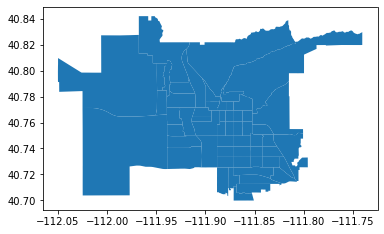

In [ ]:
#this bit is helpful in isolating just the SLC tracts
centroids = ut_tracts.centroid
ut_tracts["centroids"] = centroids
ut_tracts['coords'] = ut_tracts['geometry'].apply(lambda x: x.representative_point().coords[:])
ut_tracts = ut_tracts.drop(columns = ['OBJECTID', 'GEOID20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20','INTPTLAT20', 'INTPTLON20', 'SHAPE_Leng', 'SHAPE_Area'])

#identify ut_tracts that are in SLC
in_SLC = []

for index, row in ut_tracts.iterrows():
    #check if the census name is fine
    xx = row.coords[0][0]
    yy = row.coords[0][1]
    #check for tract name and centroid coordinates
    if (row.NAME20 in tracts) and (xx >= -112.2) and (xx <= -111.6) and (yy >= 40.4) and (yy <= 40.9) :
        in_SLC.append(True)
    else:
        in_SLC.append(False)
  
#try plotting
ut_tracts[in_SLC].plot();plt.show()

Now let's merge our data into fewer dataframes so it's easier to plot and manage.

In [ ]:
#get the names of the tracts we've identified as being in SLC
SLC_tract_names = ut_tracts.TRACTCE20[in_SLC].to_numpy()
df_tract_names = df.index.to_numpy()

#rename the index of the tract data so it matches with the census data indeces
SLC_tracts = ut_tracts.rename(index = ut_tracts.TRACTCE20)
SLC_tracts = SLC_tracts.loc[SLC_tract_names]
SLC_tracts = SLC_tracts[SLC_tracts.COUNTYFP20 == "035"]

#merge dataframes
SLC_tracts = pd.concat([SLC_tracts,df.loc[SLC_tract_names]],axis=1)

In [ ]:
#check to make sure SLC_tracts has the geometry and census data
print(SLC_tracts.head())

       STATEFP20 COUNTYFP20 TRACTCE20   NAME20  \
980000        49        035    980000     9800   
100308        49        035    100308  1003.08   
114000        49        035    114000     1140   
114100        49        035    114100     1141   
104800        49        035    104800     1048   

                                                 geometry  \
980000  POLYGON ((-112.05012 40.79902, -112.05006 40.8...   
100308  POLYGON ((-111.94361 40.78511, -111.94361 40.7...   
114000  POLYGON ((-111.91398 40.76064, -111.91390 40.7...   
114100  POLYGON ((-111.87124 40.71935, -111.87113 40.7...   
104800  POLYGON ((-111.86834 40.70687, -111.86834 40.7...   

                          centroids  \
980000  POINT (-111.99073 40.79313)   
100308  POINT (-111.93876 40.79499)   
114000  POINT (-111.89747 40.75760)   
114100  POINT (-111.85008 40.72231)   
104800  POINT (-111.85231 40.70942)   

                                             coords  DP02_0001E  DP02_0002E  \
980000  [(-111.999

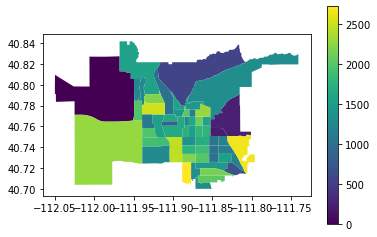

In [ ]:
#let's visualize the data, because why not?
SLC_tracts.plot("DP02_0001E",legend = True); plt.show()

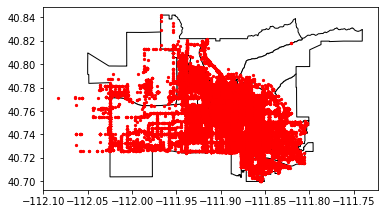

In [ ]:
#let's plot SLC_tracts with crash data (where were the crashes?)

fig,ax = plt.subplots(1,1)

SLC_tracts.plot(ax=ax,color = "white",edgecolor="black")
crashes.plot(ax=ax,marker="o",color = "red",markersize = 5)

plt.show()

## Statistical operations on the data

Under the hood the spatial data objects that geopandas handles are just Pandas dataframes, so any operation with dataframes is valid for geopandas objects.

As an initial example, let's just count the number of light fixtures per tract and the average wattage of those lights.

In [ ]:
#first, let's get a sense of what's in the wattage data
print("unique wattage values: ")
print(lights.wattage.unique())

unique wattage values: 
[ 400.  100.   nan   70.  250.  175.   50.  150. 1000.   39.  135.   85.
 9999.   55.  327.  189.  146.  145.  125.  165.    0.]


In [ ]:
num_lights = []
avg_wattage = []

for idx, row in tqdm(SLC_tracts.iterrows()):
  #print(f"row idx is {idx}")
  light_idx = lights.TRACTCE20 == idx

  #get the number of lights
  temp_num = sum(light_idx)
  num_lights.append(temp_num)

  #get the average value for these lights
  temp_avg = lights[light_idx & (lights.wattage > 0) & (lights.wattage <1000)].wattage.mean()
  avg_wattage.append(temp_avg)

print("number of lights: ")
print(num_lights)
#don't forget to add this array to the dataframe
SLC_tracts["num_lights"] = num_lights

print("average wattage: ")
print(avg_wattage)
#don't forget to add this array to the dataframe
SLC_tracts["avg_wattage"] = avg_wattage


57it [00:00, 166.68it/s]

number of lights: 
[489, 185, 1729, 716, 411, 26, 303, 106, 754, 769, 142, 647, 446, 388, 139, 330, 216, 564, 632, 363, 191, 247, 330, 194, 398, 303, 275, 301, 178, 208, 181, 219, 193, 277, 339, 576, 487, 397, 617, 112, 139, 325, 364, 420, 188, 473, 484, 285, 345, 156, 470, 207, 134, 102, 24, 190, 185]
average wattage: 
[281.0344827586207, 163.24324324324326, 300.624349635796, 229.29864253393666, 227.73936170212767, 283.3333333333333, 153.04123711340208, 333.13829787234044, 209.88235294117646, 292.44604316546764, 314.11290322580646, 296.05324074074076, 106.71319796954315, 263.8449197860963, 189.04494382022472, 172.7173913043478, 213.71794871794873, 158.22291021671828, 263.5840707964602, 303.9341692789969, 262.33870967741933, 217.53246753246754, 223.4920634920635, 212.38095238095238, 241.2488262910798, 138.5, 193.66197183098592, 155.75, 248.06451612903226, 232.67326732673268, 288.2613636363636, 253.6904761904762, 343.1283422459893, 302.94921875, 324.55696202531647, 224.03890160183067, 2

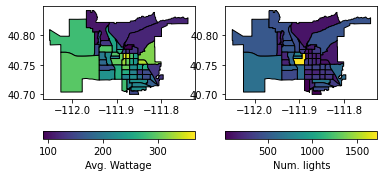

In [ ]:
#now let's plot each, the counts and then the wattage 
fig, ax = plt.subplots(ncols = 2)

SLC_tracts.plot(ax=ax[0],column = "avg_wattage",edgecolor="black",
                legend = True,legend_kwds={'label': "Avg. Wattage",'orientation': "horizontal"})
SLC_tracts.plot(ax=ax[1],column = "num_lights",edgecolor="black",
                legend = True,legend_kwds={'label': "Num. lights",'orientation': "horizontal"})

plt.show()

If we want to save this shapefile, so we don't have to recompute everything, geopandas provides that functionality.

In [ ]:
#we make a new directory just so all of the files that get generated are n a single location
!mkdir my_data

#specify where the shapefile should be saved
#the other pieces will be saved in the same directory
# first we need to drop the centroids and coords columns, for some reason gpd is unhappy trying to save those
SLC_tracts = SLC_tracts.drop(columns =['centroids', 'coords'])
SLC_tracts.to_file("./my_data/my_data.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


## Visualizing the data

There are some other fun Python tools you can use to make useful visualizations. The one we'll use is based on the package "folium", and this portion is adapted from the tutoral here: https://kodu.ut.ee/~kmoch/geopython2019/L6/interactive-map-folium.html

See also examples and other ideas here: https://python-visualization.github.io/folium/quickstart.html

In [ ]:
#this sets up a new map with prescribed view location and zoom, etc.
m = folium.Map(location=[40.7608, -111.8910], zoom_start=11.5, control_scale=True, prefer_canvas=True, width=600, height=450)

#this forces the map to be displayed
m


Let's see if we can plot our census data on top of this map.

In [ ]:
# need to make sure our data is in the right format 
SLC_tracts['geometry'] =  SLC_tracts['geometry'].to_crs(epsg=4326)
SLC_tracts['geoid'] = SLC_tracts.index.astype(str)

SLC_jsontxt = SLC_tracts[["geoid","geometry"]].to_json()

In [ ]:
# generate the interactive map with the data
m = folium.Map(location=[40.7608, -111.8910], zoom_start=11, control_scale=True, prefer_canvas=True, width=600, height=450)

# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
# Create a basic choropleth map, just polygons with some style information, where the colors are coming from the column "DP02_0001E"
folium.Choropleth( geo_data=SLC_jsontxt,fill_opacity=0.3,line_weight=1,).add_to(m)
m

In [ ]:
#the variable DP03_0063E corresponds to 
# -> Estimate!!INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)
folium.Choropleth(geo_data=SLC_jsontxt,data=SLC_tracts,
                  columns=['geoid', 'DP03_0063E'],
                  key_on="feature.id",
                  fill_opacity=0.5,
                  line_opacity=0.2,
                  line_color='white',
                  line_weight=0,
                  legend_name='Population (?)',
                  name='Population Grid',
                  highlight=False,
                  fill_color='RdBu'
                  ).add_to(m)
m

In [ ]:
#to save our beuatiful figure
outfp = "beautiful_map.html"
m.save(outfp)

There's also some functionality to "scatter" points, though it's a little clunkier.

In [ ]:
#first let's get a sense of the range of wattage values
print(lights.wattage.unique())

[ 400.  100.   nan   70.  250.  175.   50.  150. 1000.   39.  135.   85.
 9999.   55.  327.  189.  146.  145.  125.  165.    0.]


In [ ]:
#we can also add the streetlight data 
# Re-project to WGS84, Folium requires all data to be in WGS84
lights['geometry'] =  lights['geometry'].to_crs(epsg=4326)

new_lights = lights.loc[(lights['wattage'] > 0) & (lights['wattage'] <100 )]
new_lights['geoid'] = new_lights.index.astype(str)

#need a little extra work to isolate the geometry of the point
from shapely.geometry import Point

def getPoints(row, geom):
  """Returns coordinate pair tuples for the point ('lat', 'lon') of a Point geometry"""
  if isinstance(row[geom], Point):
    return (row[geom].y, row[geom].x)
  else:
    return ()

new_lights['points_tuple'] = new_lights.apply(getPoints, geom='geometry', axis=1)

#if you want to refresh the map, uncomment this
#m = folium.Map(location=[40.7608, -111.8910], zoom_start=11, control_scale=True, prefer_canvas=True, width=600, height=450)


# add lights point by point 
for idx, row in new_lights.iterrows():
  folium.CircleMarker(location=row['points_tuple'], color="yellow", radius=1.5, opacity=0.5).add_to(m)

m

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
#to save our beuatiful figure
outfp = "beautiful_map_w_lights.html"
m.save(outfp)

In [ ]:
#if you want to save it as a .png...
#solution from https://stackoverflow.com/questions/53565979/export-a-folium-map-as-a-png
#(likely won't work in google colab, need to run on your local machine)
!pip install selenium
import io
from PIL import Image

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')